In [1]:
import logging
import os

import torch
import numpy as np
from numpy import random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLaplaceApproximation


1. Construct a linear regression of weight as predicted by height, using the
adults (age 18 or greater) from the Howell1 dataset. The heights listed below
were recorded in the !Kung census, but weights were not recorded for these
individuals. Provide predicted weights and 89% compatibility intervals for
each of these individuals. That is, fill in the table below, using model-based
predictions.

    | Individual | height | expected weight | 89% interva |
    |------------|--------|-----------------|-------------|
    | 1          | 140    |                 |             |
    | 2          | 160    |                 |             |
    | 3          | 175    |                 |             |

First we need to load the data:

In [2]:
howell1_df = pd.read_csv("../data/howell1.csv")
howell1_df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


Since we don't know the dependance on agae, to avoid biasses, only records of $age>18$ are selected:


In [3]:
howell1_18_df = howell1_df[howell1_df["age"] >= 18]

To have a sense of the problem a plot of weight vs height is created:


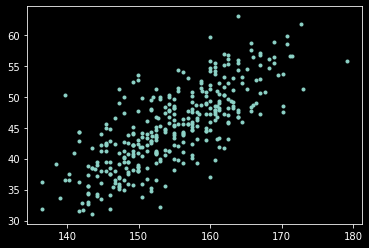

In [4]:
plt.plot(howell1_18_df.height, howell1_18_df.weight, ".")
plt.show()

We start by building a linear model for the weight as a function of height:

In [5]:
from pyro.nn import PyroSample, PyroModule
from torch import nn

In [6]:
class WeightFromHeight(PyroModule):
    def __init__(self, mean_height=0.):
        super().__init__()
        self.mean_height = mean_height
        self.linear = PyroModule[nn.Linear](1, 1)
        self.linear.bias = PyroSample(dist.Normal(60., 10.).expand([1]).to_event(1))
        self.linear.weight = PyroSample(dist.LogNormal(0., 1).expand([1, 1]).to_event(2))
        
    def forward(self, x, y=None):
        x = x.view(len(x), 1)
        x = x - self.mean_height
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y) 
        return mean

After defining he model we have to define the prior to sample from. We will the default prior, reffered as a $guide$ suggested by the pyro framework.


In [7]:
from pyro.infer.autoguide import AutoDiagonalNormal


In [8]:
mean_height = howell1_18_df.height.mean()

weight_model = WeightFromHeight(mean_height=mean_height)
guide = AutoDiagonalNormal(weight_model)


We will optimize the modl with the guide using variational inference. We let the framework to handles everything.

In [9]:
from pyro.infer import SVI, Trace_ELBO
import tqdm


In [10]:
adam = pyro.optim.Adam({"lr": 0.05})
svi = SVI(weight_model, guide, adam, loss=Trace_ELBO())


In [11]:
pyro.clear_param_store()
num_iterations = 10000
x_data = torch.Tensor(howell1_18_df.height.to_numpy())
y_data = torch.Tensor(howell1_18_df.weight.to_numpy())

tq = tqdm.autonotebook.trange(num_iterations)
for j in  tq:
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    tq.set_description(f"loss_lin = {(loss / len(howell1_18_df)):.4f}")


loss_lin = 2.8942: 100%|██████████| 10000/10000 [00:44<00:00, 225.82it/s]


After the model parameters were inffered from the data, we can sample the distribution and create a posterior predictive distribution. From that distribution we can inffer the $89\%$ confidence interval for the weight.

In [12]:
from pyro.infer import Predictive


x_table = torch.Tensor([140, 160, 175])

predictive = Predictive(weight_model, guide=guide, num_samples=1000,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_table)


In [13]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5.5%": v.kthvalue(int(len(v) * 0.055), dim=0)[0],
            "94.5%": v.kthvalue(int(len(v) * 0.945), dim=0)[0],
        }
    return site_stats


pred_summary = summary(samples)


For the lineral mode of weight as a linear function of height:

In [14]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "height": x_table,
    "mu_mean": mu["mean"],
    "mu_perc_5.5": mu["5.5%"],
    "mu_perc_94.5": mu["94.5%"],
    "y_mean": y["mean"],
    "y_perc_5.5": y["5.5%"],
    "y_perc_94.5": y["94.5%"],
})
predictions

,height,mu_mean,mu_perc_5.5,mu_perc_94.5,y_mean,y_perc_5.5,y_perc_94.5
0,140.0,36.027813,35.132317,36.858528,36.294968,29.509041,43.193035
1,160.0,48.396389,47.981091,48.813015,48.212460,41.460472,54.981831
2,175.0,57.672829,56.558609,58.931301,57.739834,51.025066,64.663208


So for this model:  

| Individual | height | expected weight | 89% interva |
|------------|--------|-----------------|-------------|
| 1          | 140    | 36.2            | 29.4 - 42.7 |
| 2          | 160    | 48.1            | 41.5 - 55.1 |
| 3          | 175    | 57.0            | 50.1 - 63.8 |

We can draw the $89\%$ confidence interval for the weight as a function of height:

In [15]:
samples_data = predictive(x_data)
pred_data_summary = summary(samples_data)


In [16]:
mu_data = pred_data_summary["_RETURN"]
pred_y_data = pred_data_summary["obs"]
predictions_data = pd.DataFrame({
    "height": x_data,
    "mu_mean": mu_data["mean"],
    "mu_perc_5.5": mu_data["5.5%"],
    "mu_perc_94.5": mu_data["94.5%"],
    "y_mean": pred_y_data["mean"],
    "y_perc_5.5": pred_y_data["5.5%"],
    "y_perc_94.5": pred_y_data["94.5%"],
    "weight": y_data,
})


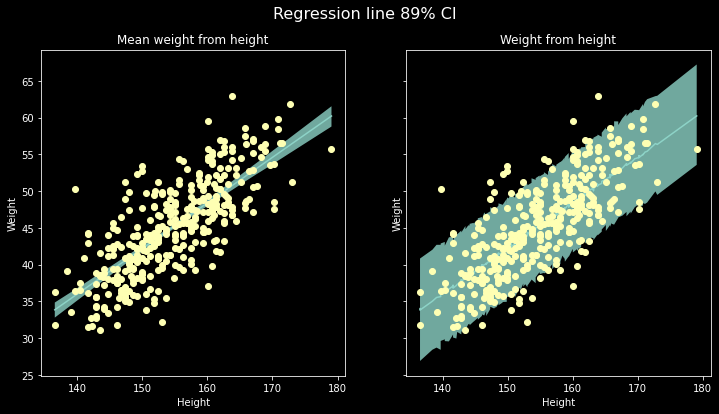

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Regression line 89% CI", fontsize=16)
preds_data = predictions_data.sort_values("height")
ax[0].plot(preds_data["height"],
        preds_data["mu_mean"])
ax[0].fill_between(preds_data["height"],
                   preds_data["mu_perc_5.5"],
                   preds_data["mu_perc_94.5"],
                   alpha=0.8)
ax[0].plot(preds_data["height"],
           preds_data["weight"],
           "o")
ax[0].set(xlabel="Height", 
          ylabel="Weight",
          title="Mean weight from height")

ax[1].plot(preds_data["height"],
           preds_data["y_mean"])
ax[1].fill_between(preds_data["height"],
                   preds_data["y_perc_5.5"],
                   preds_data["y_perc_94.5"],
                   alpha=0.8)
ax[1].plot(preds_data["height"],
           preds_data["weight"],
           "o")
ax[1].set(xlabel="Height", 
          ylabel="Weight",
          title="Weight from height")
pass

2. From the Howell1 dataset, consider only the people younger than 13 years old. Estimate the causal association between age and weight. Assume that age influences weight through two paths. First, age influences height, and height influences weight. Second, age directly influences weight through agerelated changes in muscle growth and body proportions. All of this implies this causal model (DAG):  
![DAG](DAG02.png)  
Use a linear regression to estimate the total (not just direct) causal effect of each year of growth on weight. Be sure to carefully consider the priors. Try using prior predictive simulation to assess what they imply.

We can build a linar model for the weight as a function of age in the same way it was done for the height.

In [18]:
class WeightFromAge(PyroModule):
    def __init__(self):
        super().__init__()
        self.linear = PyroModule[nn.Linear](1, 1)
        self.linear.bias = PyroSample(dist.Normal(5., 1.).expand([1]).to_event(1))
        self.linear.weight = PyroSample(dist.LogNormal(0., 1).expand([1, 1]).to_event(2))
        
    def forward(self, x, y=None):
        x = x.view(len(x), 1)
        sigma = pyro.sample("age_sigma", dist.Exponential(1.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("age_data", x.shape[0]):
            obs = pyro.sample("age_obs", dist.Normal(mean, sigma), obs=y) 
        return mean

In [19]:
howell1_13_df = howell1_df[howell1_df["age"] < 13]

In [20]:
weight_age_model = WeightFromAge()
guide_age = AutoDiagonalNormal(weight_age_model)


In [21]:
adam_age = pyro.optim.Adam({"lr": 0.05})
svi_age = SVI(weight_age_model, guide_age, adam_age, loss=Trace_ELBO())


In [22]:
pyro.clear_param_store()
num_iterations = 1000
x_data = torch.Tensor(howell1_13_df.age.to_numpy())
y_data = torch.Tensor(howell1_13_df.weight.to_numpy())

tq = tqdm.autonotebook.trange(num_iterations)
for j in  tq:
    # calculate the loss and take a gradient step
    loss_age = svi_age.step(x_data, y_data)
    tq.set_description(f"loss_lin = {(loss_age / len(howell1_13_df)):.4f}")


loss_lin = 2.4261: 100%|██████████| 1000/1000 [00:04<00:00, 227.50it/s]


In [23]:
predictive_age = Predictive(weight_age_model, guide=guide_age, num_samples=1000,
                            return_sites=("linear.weight", "linear.bias", "age_sigma"))

In [24]:
s_age = summary(predictive_age(torch.Tensor([0.])))
pd.DataFrame(
    {stat: {
            "linear_weight": s_age["linear.weight"][stat][0, 0, 0].item(),
            "linear_bias": s_age["linear.bias"][stat][0, 0].item(),
            "sigma": s_age["age_sigma"][stat][0].item()
        } for stat in ["mean", "std", "5.5%", "94.5%"]
    })

,mean,std,5.5%,94.5%
linear_weight,1.390633,0.033308,1.340080,1.445960
linear_bias,7.198942,0.198837,6.880605,7.505920
sigma,2.500061,0.150181,2.266605,2.745358
